In [ ]:
# 1. Daten einlesen und vorbereiten
import pandas as pd

df = pd.read_csv("spotify_project.csv", encoding='ISO-8859-1')
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')
df['Released Year'] = df['Release Date'].dt.year

# Entferne Kommas aus Zahlen und konvertiere in numerische Werte
for col in ['Spotify Streams', 'YouTube Views', 'TikTok Likes', 'TikTok Views', 'TikTok Posts']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(',', '').replace('nan', '')
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Filtere ungültige Zeilen raus
df = df.dropna(subset=['Track', 'Artist', 'Released Year'])


In [ ]:
# 2. RDF Graph und Ontologie definieren

from rdflib import Graph, Literal, RDF, URIRef, Namespace, XSD
from rdflib.namespace import OWL, RDFS
import re

g = Graph()
EX = Namespace("http://example.org/spotify/")
g.bind("ex", EX)
g.bind("owl", OWL)
g.bind("rdfs", RDFS)
g.bind("xsd", XSD)

# Klassen
g.add((EX.Song, RDF.type, URIRef("http://www.w3.org/2002/07/owl#Class")))
g.add((EX.Artist, RDF.type, URIRef("http://www.w3.org/2002/07/owl#Class")))
g.add((EX.Album, RDF.type, URIRef("http://www.w3.org/2002/07/owl#Class")))
g.add((EX.Metric, RDF.type, URIRef("http://www.w3.org/2002/07/owl#Class")))

# Objekt-Properties
g.add((EX.hasArtist, RDF.type, URIRef("http://www.w3.org/2002/07/owl#ObjectProperty")))
g.add((EX.hasArtist, URIRef("http://www.w3.org/2000/01/rdf-schema#domain"), EX.Song))
g.add((EX.hasArtist, URIRef("http://www.w3.org/2000/01/rdf-schema#range"), EX.Artist))

g.add((EX.hasAlbum, RDF.type, URIRef("http://www.w3.org/2002/07/owl#ObjectProperty")))
g.add((EX.hasAlbum, URIRef("http://www.w3.org/2000/01/rdf-schema#domain"), EX.Song))
g.add((EX.hasAlbum, URIRef("http://www.w3.org/2000/01/rdf-schema#range"), EX.Album))

g.add((EX.hasMetric, RDF.type, URIRef("http://www.w3.org/2002/07/owl#ObjectProperty")))
g.add((EX.hasMetric, URIRef("http://www.w3.org/2000/01/rdf-schema#domain"), EX.Song))
g.add((EX.hasMetric, URIRef("http://www.w3.org/2000/01/rdf-schema#range"), EX.Metric))

# Datentyp-Properties für Metric
g.add((EX.metricValue, RDF.type, URIRef("http://www.w3.org/2002/07/owl#DatatypeProperty")))
g.add((EX.metricValue, URIRef("http://www.w3.org/2000/01/rdf-schema#domain"), EX.Metric))
g.add((EX.metricValue, URIRef("http://www.w3.org/2000/01/rdf-schema#range"), XSD.float))

g.add((EX.metricType, RDF.type, URIRef("http://www.w3.org/2002/07/owl#DatatypeProperty")))
g.add((EX.metricType, URIRef("http://www.w3.org/2000/01/rdf-schema#domain"), EX.Metric))
g.add((EX.metricType, URIRef("http://www.w3.org/2000/01/rdf-schema#range"), XSD.string))

g.add((EX.metricDate, RDF.type, URIRef("http://www.w3.org/2002/07/owl#DatatypeProperty")))
g.add((EX.metricDate, URIRef("http://www.w3.org/2000/01/rdf-schema#domain"), EX.Metric))
g.add((EX.metricDate, URIRef("http://www.w3.org/2000/01/rdf-schema#range"), XSD.date))


def uri_safe(name):
    if not isinstance(name, str):
        return URIRef(EX + "Unknown")
    clean_name = re.sub(r"[^a-zA-Z0-9_\-\.]", "", name.replace(" ", "_"))
    return URIRef(EX + clean_name)


In [ ]:
# 3. RDF-Instanzen erstellen

for i, row in df.iterrows():
    track_uri = URIRef(EX + f"track_{i}")
    g.add((track_uri, RDF.type, EX.Song))
    g.add((track_uri, URIRef("http://www.w3.org/2000/01/rdf-schema#label"), Literal(row['Track'])))

    artist_uri = uri_safe(row['Artist'])
    g.add((artist_uri, RDF.type, EX.Artist))
    g.add((track_uri, EX.hasArtist, artist_uri))

    if 'Album Name' in df.columns and pd.notna(row['Album Name']):
        album_uri = uri_safe(row['Album Name'])
        g.add((album_uri, RDF.type, EX.Album))
        g.add((track_uri, EX.hasAlbum, album_uri))

    # Social-Media- und Streaming-Metriken hinzufügen
    metric_fields = {
        "Spotify Streams": row.get("Spotify Streams", None),
        "YouTube Views": row.get("YouTube Views", None),
        "TikTok Likes": row.get("TikTok Likes", None),
        "TikTok Views": row.get("TikTok Views", None),
        "TikTok Posts": row.get("TikTok Posts", None)
    }

    for metric_name, metric_value in metric_fields.items():
        if metric_value and pd.notna(metric_value):
            metric_uri = URIRef(EX + f"metric_{i}_{metric_name.replace(' ', '_')}")
            g.add((metric_uri, RDF.type, EX.Metric))
            g.add((metric_uri, EX.metricType, Literal(metric_name)))
            g.add((metric_uri, EX.metricValue, Literal(float(metric_value), datatype=XSD.float)))

            if 'Release Date' in df.columns and pd.notna(row['Release Date']):
                date_val = row['Release Date']
                if isinstance(date_val, pd.Timestamp):
                    date_val = date_val.date().isoformat()
                g.add((metric_uri, EX.metricDate, Literal(date_val, datatype=XSD.date)))

            g.add((track_uri, EX.hasMetric, metric_uri))

g.serialize(destination="spotify_extended.ttl", format="turtle")


<Graph identifier=Nd6d5542627bb47b2927be038bb5b051c (<class 'rdflib.graph.Graph'>)>

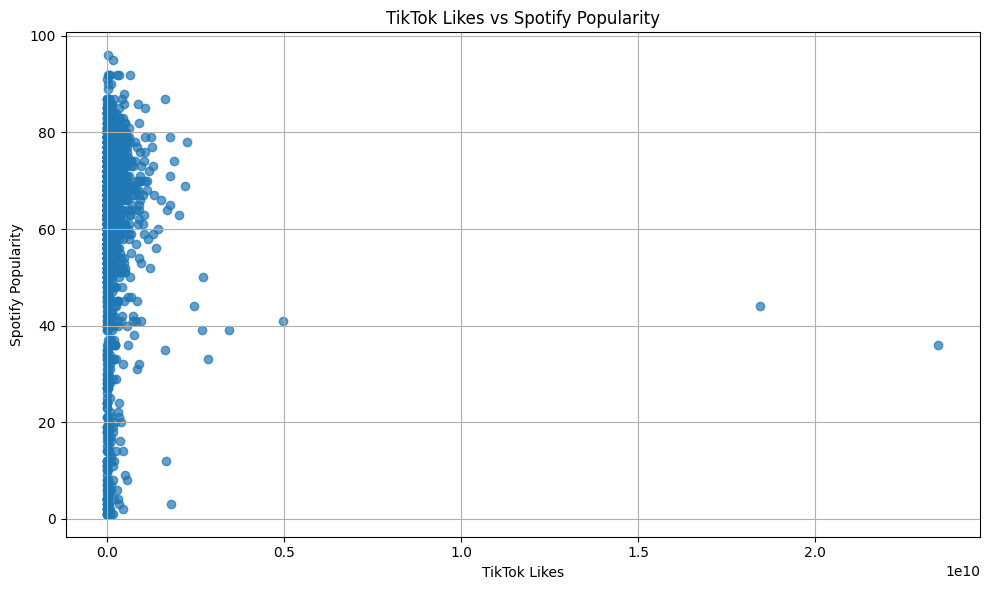

Korrelation zwischen TikTok Likes und Spotify Popularity: -0.05


In [ ]:
# 4. Analyse TikTok Likes vs. Spotify Popularity

import matplotlib.pyplot as plt

df["TikTok Likes"] = df["TikTok Likes"].replace(",", "", regex=True).astype(float)
df["Spotify Popularity"] = pd.to_numeric(df["Spotify Popularity"], errors="coerce")

data = df[["Track", "TikTok Likes", "Spotify Popularity"]].dropna()

plt.figure(figsize=(10, 6))
plt.scatter(data["TikTok Likes"], data["Spotify Popularity"], alpha=0.7)
plt.title("TikTok Likes vs Spotify Popularity")
plt.xlabel("TikTok Likes")
plt.ylabel("Spotify Popularity")
plt.grid(True)
plt.tight_layout()
plt.show()

correlation = data["TikTok Likes"].corr(data["Spotify Popularity"])
print(f"Korrelation zwischen TikTok Likes und Spotify Popularity: {correlation:.2f}")



📊 Korrelationsmatrix:
                    TikTok Posts  TikTok Likes  TikTok Views  \
TikTok Posts            1.000000      0.525660      0.550373   
TikTok Likes            0.525660      1.000000      0.992744   
TikTok Views            0.550373      0.992744      1.000000   
Spotify Popularity     -0.181855     -0.048354     -0.061420   

                    Spotify Popularity  
TikTok Posts                 -0.181855  
TikTok Likes                 -0.048354  
TikTok Views                 -0.061420  
Spotify Popularity            1.000000  

📈 Regressionszusammenfassung:
                            OLS Regression Results                            
Dep. Variable:     Spotify Popularity   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     44.19
Date:                Sun, 21 Sep 2025   Prob (F-statistic):           5.65e-28
Time:                    

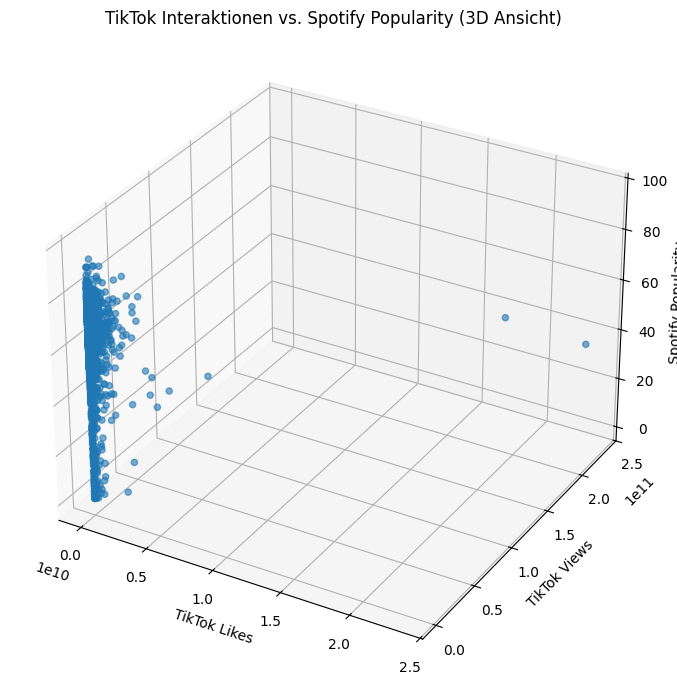

In [ ]:
# 5. Multiple Regression und 3D Plot (TikTok Interaktionen vs. Spotify Popularity)

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm

df["TikTok Likes"] = df["TikTok Likes"].replace(",", "", regex=True).astype(float)
df["TikTok Posts"] = df["TikTok Posts"].replace(",", "", regex=True).astype(float)
df["TikTok Views"] = df["TikTok Views"].replace(",", "", regex=True).astype(float)
df["Spotify Popularity"] = pd.to_numeric(df["Spotify Popularity"], errors="coerce")

data = df[["TikTok Posts", "TikTok Likes", "TikTok Views", "Spotify Popularity"]].dropna()

print("\nKorrelationsmatrix:")
print(data.corr())

X = data[["TikTok Posts", "TikTok Likes", "TikTok Views"]]
y = data["Spotify Popularity"]
X = sm.add_constant(X) 

model = sm.OLS(y, X).fit()
print("\nRegressionszusammenfassung:")
print(model.summary())

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data["TikTok Likes"], data["TikTok Views"], data["Spotify Popularity"], alpha=0.6)
ax.set_xlabel("TikTok Likes")
ax.set_ylabel("TikTok Views")
ax.set_zlabel("Spotify Popularity")
ax.set_title("TikTok Interaktionen vs. Spotify Popularity (3D Ansicht)")

plt.tight_layout()
plt.show()


In [8]:
# Helferfunktion
def run(q):
    return [ {str(v): (row[v] if v in row.asdict() else None) for v in row.labels} for row in g.query(q) ]


In [ ]:
# SPARQL Abfragen getestet mit Apache Jena Fuseki mit Docker und in Jupyter Notebook

# Welche Künstler:innen haben die meisten Songs?
q1 = """
PREFIX ex: <http://example.org/spotify/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?artist (COUNT(?song) AS ?numSongs)
WHERE {
  ?song rdf:type ex:Song ;
        ex:hasArtist ?artist .
}
GROUP BY ?artist
ORDER BY DESC(?numSongs)
LIMIT 20
"""
for row in g.query(q1):
    print(row.artist, row.numSongs)


http://example.org/spotify/Taylor_Swift 63
http://example.org/spotify/Drake 63
http://example.org/spotify/Bad_Bunny 60
http://example.org/spotify/KAROL_G 32
http://example.org/spotify/The_Weeknd 31
http://example.org/spotify/Travis_Scott 30
http://example.org/spotify/Billie_Eilish 27
http://example.org/spotify/Ariana_Grande 26
http://example.org/spotify/Future 23
http://example.org/spotify/Post_Malone 22
http://example.org/spotify/Peso_Pluma 22
http://example.org/spotify/Juice_WRLD 21
http://example.org/spotify/Olivia_Rodrigo 20
http://example.org/spotify/Morgan_Wallen 20
http://example.org/spotify/Lil_Baby 20
http://example.org/spotify/Doja_Cat 19
http://example.org/spotify/Rauw_Alejandro 19
http://example.org/spotify/Kendrick_Lamar 18
http://example.org/spotify/Dua_Lipa 17
http://example.org/spotify/Bizarrap 17


In [ ]:
# Welche Alben haben die meisten Songs?
q2 = """
PREFIX ex: <http://example.org/spotify/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?album (COUNT(?song) AS ?numSongs)
WHERE {
  ?song rdf:type ex:Song ;
        ex:hasAlbum ?album .
}
GROUP BY ?album
ORDER BY DESC(?numSongs)
LIMIT 20
"""
for row in g.query(q2):
    print(row.album, row.numSongs)


http://example.org/spotify/ 30
http://example.org/spotify/Un_Verano_Sin_Ti 20
http://example.org/spotify/THE_TORTURED_POETS_DEPARTMENT 18
http://example.org/spotify/nadie_sabe_lo_que_va_a_pasar_ma 16
http://example.org/spotify/UTOPIA 15
http://example.org/spotify/For_All_The_Dogs 15
http://example.org/spotify/Full_Circle_The_Live_Anthology 13
http://example.org/spotify/WE_DONT_TRUST_YOU 11
http://example.org/spotify/Papercuts 11
http://example.org/spotify/Her_Loss 11
http://example.org/spotify/HIT_ME_HARD_AND_SOFT 10
http://example.org/spotify/_-_Single 10
http://example.org/spotify/HEROES__VILLAINS 8
http://example.org/spotify/Midnights 7
http://example.org/spotify/1989_Taylors_Version 7
http://example.org/spotify/Amor_Prohibido_Remasterizado_202430th_Anniversary 7
http://example.org/spotify/Certified_Lover_Boy 7
http://example.org/spotify/YHLQMDLG 7
http://example.org/spotify/__ 6
http://example.org/spotify/_ 6


In [ ]:
# Welche Künstler:innen haben die meisten Alben?
q3 = """
PREFIX ex: <http://example.org/spotify/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?artist (COUNT(DISTINCT ?album) AS ?albumCount)
WHERE {
  ?song rdf:type ex:Song ;
        ex:hasArtist ?artist ;
        ex:hasAlbum ?album .
}
GROUP BY ?artist
ORDER BY DESC(?albumCount)
LIMIT 15
"""
for row in g.query(q3):
    print(row.artist, "-", row.albumCount, "Alben")

http://example.org/spotify/Drake - 27 Alben
http://example.org/spotify/KAROL_G - 25 Alben
http://example.org/spotify/Taylor_Swift - 21 Alben
http://example.org/spotify/Peso_Pluma - 21 Alben
http://example.org/spotify/Post_Malone - 20 Alben
http://example.org/spotify/The_Weeknd - 19 Alben
http://example.org/spotify/Juice_WRLD - 18 Alben
http://example.org/spotify/Ariana_Grande - 17 Alben
http://example.org/spotify/Calvin_Harris - 17 Alben
http://example.org/spotify/Billie_Eilish - 16 Alben
http://example.org/spotify/Bizarrap - 16 Alben
http://example.org/spotify/Imagine_Dragons - 16 Alben
http://example.org/spotify/Feid - 16 Alben
http://example.org/spotify/Rauw_Alejandro - 16 Alben
http://example.org/spotify/Bad_Bunny - 15 Alben


In [ ]:
# Wie viele Metriken gibt es pro Typ?
q4 = """
PREFIX ex: <http://example.org/spotify/>

SELECT ?metricType (COUNT(?metric) AS ?metricCount)
WHERE {
  ?metric a ex:Metric ;
          ex:metricType ?metricType .
}
GROUP BY ?metricType
ORDER BY DESC(?metricCount)
"""
for row in g.query(q4):
    print(f"{row.metricType}: {row.metricCount} Einträge")

Spotify Streams: 4487 Einträge
YouTube Views: 4292 Einträge
TikTok Likes: 3620 Einträge
TikTok Views: 3619 Einträge
TikTok Posts: 3427 Einträge


In [ ]:
# Welche Alben haben Songs von mehreren Künstler:innen?
q5 = """
PREFIX ex: <http://example.org/spotify/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?album (COUNT(DISTINCT ?artist) AS ?artistCount) (COUNT(?song) AS ?songCount)
WHERE {
  ?song rdf:type ex:Song ;
        ex:hasArtist ?artist ;
        ex:hasAlbum ?album .
}
GROUP BY ?album
HAVING (COUNT(DISTINCT ?artist) > 1)
ORDER BY DESC(?artistCount)
LIMIT 15
"""
for row in g.query(q5):
    print(f"{row.album}: {row.artistCount} Künstler, {row.songCount} Songs")


http://example.org/spotify/: 24 Künstler, 30 Songs
http://example.org/spotify/Full_Circle_The_Live_Anthology: 13 Künstler, 13 Songs
http://example.org/spotify/_-_Single: 8 Künstler, 10 Songs
http://example.org/spotify/__: 6 Künstler, 6 Songs
http://example.org/spotify/_: 6 Künstler, 6 Songs
http://example.org/spotify/EPIC_AF: 5 Künstler, 5 Songs
http://example.org/spotify/Encanto_Original_Motion_Picture_Soundtrack: 4 Künstler, 4 Songs
http://example.org/spotify/Todo_Exitos_2014_Los_Nmero_1_Del_A: 4 Künstler, 4 Songs
http://example.org/spotify/Alone: 4 Künstler, 4 Songs
http://example.org/spotify/Dua_Lipa_Complete_Edition: 4 Künstler, 4 Songs
http://example.org/spotify/NAME: 3 Künstler, 5 Songs
http://example.org/spotify/Faded: 3 Künstler, 3 Songs
http://example.org/spotify/Los_Nmeros_1_De_40_El_Disco_De_Los_: 3 Künstler, 3 Songs
http://example.org/spotify/The_RCA-List_Vol._2: 3 Künstler, 3 Songs
http://example.org/spotify/Papercuts: 2 Künstler, 11 Songs


In [ ]:
# Welche Songs haben mehr als 1 Milliarde Spotify Streams? (mit Artist)
q6 = """
PREFIX ex: <http://example.org/spotify/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?songLabel ?artist ?value
WHERE {
  ?song rdf:type ex:Song ;
        rdfs:label ?songLabel ;
        ex:hasArtist ?artist ;
        ex:hasMetric ?m .
  ?m ex:metricType "Spotify Streams" ;
     ex:metricValue ?value .
  FILTER(?value > 1000000000)
}
LIMIT 20
"""
for row in g.query(q6):
    try:
        value = float(str(row.value))
        print(f"{row.songLabel} von {row.artist}: {value:,.0f} Streams")
    except (ValueError, TypeError):
        print(f"{row.songLabel} von {row.artist}: {row.value} Streams")


Flowers von http://example.org/spotify/Miley_Cyrus: 2,031,280,633 Streams
Danza Kuduro - Cover von http://example.org/spotify/MUSIC_LAB_JPN: 1,653,018,119 Streams
greedy von http://example.org/spotify/Tate_McRae: 1,258,569,694 Streams
As It Was von http://example.org/spotify/Harry_Styles: 3,301,814,535 Streams
Paint The Town Red von http://example.org/spotify/Doja_Cat: 1,065,399,331 Streams
Danza Kuduro - Cover von http://example.org/spotify/MUSIC_LAB_JPN: 1,655,575,417 Streams
STAY (with Justin Bieber) von http://example.org/spotify/The_Kid_LAROI: 3,107,100,349 Streams
Numb / Encore von http://example.org/spotify/JAY-Z: 1,003,215,671 Streams
Danza Kuduro - Cover von http://example.org/spotify/LOVE_BGM_JPN: 1,645,079,292 Streams
Dance Monkey von http://example.org/spotify/Tones_And_I: 3,071,214,106 Streams
I'm Good (Blue) von http://example.org/spotify/David_Guetta: 1,658,229,422 Streams
Daylight von http://example.org/spotify/David_Kushner: 1,126,820,069 Streams
Danza Kuduro - Cover v

In [43]:
# Welche Songs haben mehr als 1 Milliarde Spotify Streams?
q7 = """
PREFIX ex: <http://example.org/spotify/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?songLabel ?artist ?postValue
WHERE {
  ?song rdf:type ex:Song ;
        rdfs:label ?songLabel ;
        ex:hasArtist ?artist ;
        ex:hasMetric ?m .
  ?m ex:metricType "TikTok Posts" ;
     ex:metricValue ?postValue .
  FILTER(?postValue > 1000000)
}
LIMIT 20
"""
print("Virale Songs mit >1M TikTok Posts:")
for row in g.query(q7):
    try:
        posts = float(str(row.postValue))
        print(f"{row.songLabel} - {row.artist}: {posts:,.0f} Posts")
    except:
        print(f"{row.songLabel} - {row.artist}: {row.postValue} Posts")


Virale Songs mit >1M TikTok Posts:
MILLION DOLLAR BABY - http://example.org/spotify/Tommy_Richman: 5,767,700 Posts
i like the way you kiss me - http://example.org/spotify/Artemas: 3,025,400 Posts
Flowers - http://example.org/spotify/Miley_Cyrus: 7,189,811 Posts
Lovin On Me - http://example.org/spotify/Jack_Harlow: 4,202,367 Posts
Gata Only - http://example.org/spotify/FloyyMenor: 3,500,000 Posts
LALA - http://example.org/spotify/Myke_Towers: 11,054,500 Posts
greedy - http://example.org/spotify/Tate_McRae: 2,294,429 Posts
As It Was - http://example.org/spotify/Harry_Styles: 2,755,903 Posts
Paint The Town Red - http://example.org/spotify/Doja_Cat: 3,091,732 Posts
TEXAS HOLD 'EM - http://example.org/spotify/Beyonc: 1,470,500 Posts
Future - http://example.org/spotify/official_sound_studio: 9,453,333 Posts
Beat Automotivo Tan Tan Tan Viral - http://example.org/spotify/WZ_Beat: 37,621,885 Posts
STAY (with Justin Bieber) - http://example.org/spotify/The_Kid_LAROI: 7,485,966 Posts
Baby Shark -

In [ ]:
# Welche Metriken gibt es pro Song?
q8 = """
PREFIX ex: <http://example.org/spotify/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?song ?type ?value
WHERE {
  ?song rdf:type ex:Song ;
        ex:hasMetric ?m .
  ?m ex:metricType ?type ;
     ex:metricValue ?value .
}
ORDER BY ?song ?type
LIMIT 200
"""
for row in g.query(q8):
    print(row.song, "-", row.type, ":", row.value)


http://example.org/spotify/track_0 - Spotify Streams : 390470936.0
http://example.org/spotify/track_0 - TikTok Likes : 651565900.0
http://example.org/spotify/track_0 - TikTok Posts : 5767700.0
http://example.org/spotify/track_0 - TikTok Views : 5332281936.0
http://example.org/spotify/track_0 - YouTube Views : 84274754.0
http://example.org/spotify/track_1 - Spotify Streams : 323703884.0
http://example.org/spotify/track_1 - TikTok Likes : 35223547.0
http://example.org/spotify/track_1 - TikTok Posts : 674700.0
http://example.org/spotify/track_1 - TikTok Views : 208339025.0
http://example.org/spotify/track_1 - YouTube Views : 116347040.0
http://example.org/spotify/track_10 - Spotify Streams : 250080413.0
http://example.org/spotify/track_10 - TikTok Likes : 184500.0
http://example.org/spotify/track_10 - TikTok Views : 2100000.0
http://example.org/spotify/track_10 - YouTube Views : 32229063.0
http://example.org/spotify/track_100 - Spotify Streams : 5157486.0
http://example.org/spotify/track_

In [15]:
# Neuester Messzeitpunkt je Metrik-Typ
q9 = """
PREFIX ex: <http://example.org/spotify/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?type (MAX(?date) AS ?latestDate)
WHERE {
  ?m a ex:Metric ;
     ex:metricType ?type ;
     ex:metricDate ?date .
}
GROUP BY ?type
ORDER BY ?type
"""
for row in g.query(q9):
    print(row.type, row.latestDate)


Spotify Streams 2024-06-14
TikTok Likes 2024-06-07
TikTok Posts 2024-06-11
TikTok Views 2024-06-07
YouTube Views 2024-06-12


In [42]:
# Welche Songs hat Taylor Swift? (bestimmter Artist)
q10 = """
PREFIX ex: <http://example.org/spotify/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?song ?album
WHERE {
  ?song rdf:type ex:Song ;
        ex:hasArtist ex:Taylor_Swift ;
        ex:hasAlbum ?album .
}
LIMIT 100
"""
for row in g.query(q10):
    print(row.song, row.album)


http://example.org/spotify/track_16 http://example.org/spotify/THE_TORTURED_POETS_DEPARTMENT
http://example.org/spotify/track_90 http://example.org/spotify/Midnights
http://example.org/spotify/track_239 http://example.org/spotify/1989_Taylors_Version
http://example.org/spotify/track_266 http://example.org/spotify/THE_TORTURED_POETS_DEPARTMENT
http://example.org/spotify/track_452 http://example.org/spotify/Lover
http://example.org/spotify/track_464 http://example.org/spotify/1989_Deluxe
http://example.org/spotify/track_507 http://example.org/spotify/THE_TORTURED_POETS_DEPARTMENT
http://example.org/spotify/track_597 http://example.org/spotify/1989_Deluxe
http://example.org/spotify/track_866 http://example.org/spotify/THE_TORTURED_POETS_DEPARTMENT
http://example.org/spotify/track_880 http://example.org/spotify/Look_What_You_Made_Me_Do
http://example.org/spotify/track_980 http://example.org/spotify/THE_TORTURED_POETS_DEPARTMENT
http://example.org/spotify/track_1013 http://example.org/spoti